In [183]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from PIL import Image as I

from imgaug import augmenters as iaa
from torchsummary import summary

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1

In [28]:
# dataset = datasets.ImageFolder(root='./data-nodules2d', transform = transforms.Compose([transforms.ToTensor()]))
dataset = datasets.CIFAR10('.', transform = transforms.Compose([transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.train_data), len(dataloader)

(50000, 50000)

In [98]:
seq = iaa.GaussianBlur(sigma=(0, 1)) # blur images with a sigma of 0 to 3.0

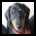

In [171]:
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=200, unconfined=True))

In [174]:
def augmentation(im, num=3):
    """
    image: 1, 3, n, n tensor
    
    output: num, 3, n, n tensor
    """
    
    transformations = [
        iaa.Crop(px=(0, 10)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    ]

    im = im[0].permute(1, 2, 0).numpy()
    return torch.Tensor([t(image=im) for t in transformations]).permute(0, 3, 1, 2)

In [175]:
aug = augmentation(fixed_x)

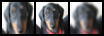

In [176]:
save_image(aug, 'real_image.png')
display(Image('real_image.png', width=500, unconfined=True))

In [186]:
class Net(nn.Module):
    def __init__(self, d=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, d)
        self.fc3 = nn.Linear(d, 120)
        self.fc4 = nn.Linear(120, 16 * 5 * 5)
        self.conv3 = nn.Conv2d(16, 6, 5)
        self.conv4 = nn.Conv2d(6, 3, 5)

        
    def encoder(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    
    def pooling(self, vectors):
        return vectors.mean(dim=0)
    
    def decoder(self, vector):
        x = self.fc3(vector)
        x = self.fc4(x) 
        
        # 1, 400 --> 1, 16, 5, 5
        


net = Net()

In [187]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
)

In [188]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
Total params: 61,156
Trainable params: 61,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [189]:
aug.shape

torch.Size([3, 3, 32, 32])

In [194]:
net(aug).mean(dim=0).shape

torch.Size([84])